# Set up Environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
import zipfile
import cv2

from collections import OrderedDict
from PIL import Image
import hashlib

import random as rn

from glob import glob

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version: ", sys.version)
print("Tensorflow Version: ", tf.__version__)

Python Version:  3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version:  2.4.0


### Set up for using GPU

In [3]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")



Using only GPU device /physical_device:GPU:0

GPU is available


### Data Preparation Part 1 (Handle Base Dataset)

In [5]:
# unzip dataset file
path_to_zip_file = './Dataset/Flowers.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('./Dataset/')
    zip_ref.close()

path_to_zip_file = './Dataset/FlowersAdded.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('./Dataset/')
    zip_ref.close()

In [22]:
# get name of flower types (these will use as official categories)
base_dir = './Dataset/Flowers/'
dataset_categories = [f.name for f in os.scandir(base_dir) if f.is_dir()]
print(dataset_categories)

num_classes = len(dataset_categories)
print("Number of flower categories: " + str(num_classes))

['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
Number of flower categories: 8


In [24]:
# Set up path of image file
base_image_path=[]
base_flower=[]
for category in dataset_categories:
    dir_link = base_dir + category + "/"
    for img_path in os.listdir(dir_link):
        base_image_path.append(dir_link + img_path)
        base_flower.append(category)

Image_path = pd.Series(base_image_path, name="Image_Path").astype(str)
Image_path.head()

0      ./Dataset/Flowers/Babi/babi_1.jpg
1     ./Dataset/Flowers/Babi/babi_10.jpg
2    ./Dataset/Flowers/Babi/babi_100.jpg
3    ./Dataset/Flowers/Babi/babi_101.jpg
4    ./Dataset/Flowers/Babi/babi_102.jpg
Name: Image_Path, dtype: object

In [25]:
# Set up flower image categories and combine to get dataframe
Flowers=pd.Series(base_flower, name="Flower_Types")

base_dataset=pd.concat([Image_path, Flowers], axis=1)
base_dataset=base_dataset.sample(frac=1).reset_index(drop = True)


base_dataset.head(5)

,Image_Path,Flower_Types
0,./Dataset/Flowers/Tana/tana_297.jpg,Tana
1,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum
2,./Dataset/Flowers/Tana/tana_584.jpg,Tana
3,./Dataset/Flowers/Babi/babi_343.jpg,Babi
4,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum


Exploration Data Analysis (EDA)

In [26]:
base_dataset.shape

(4621, 2)

<AxesSubplot:>

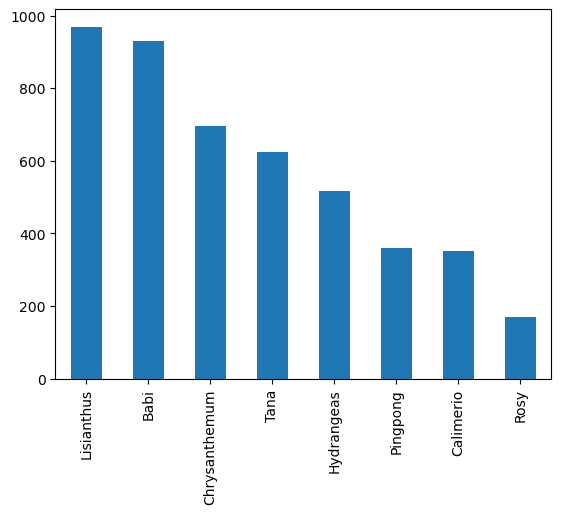

In [27]:
base_dataset['Flower_Types'].value_counts().plot.bar()

In [28]:
# So we can see that the data is imbalance so I decided to use other data source from outside

print(base_dataset['Flower_Types'].value_counts().to_frame())
print("\n")
print(base_dataset['Flower_Types'].value_counts(normalize=True).to_frame())

               Flower_Types
Lisianthus              969
Babi                    931
Chrysanthemum           696
Tana                    623
Hydrangeas              518
Pingpong                360
Calimerio               353
Rosy                    171


               Flower_Types
Lisianthus         0.209695
Babi               0.201472
Chrysanthemum      0.150617
Tana               0.134819
Hydrangeas         0.112097
Pingpong           0.077905
Calimerio          0.076390
Rosy               0.037005


### Data Preparation Part 2 (Handle Data From Outside and Combine with Base Dataset)


In [29]:
# This function returns the SHA-256 hash of a file.
def get_file_hash(filepath):
    
    sha256_hash = hashlib.sha256()
    with open(filepath, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()


# This function use to find duplicate images in dataset when combined
def find_duplicate_images(directory, other_directory):
    duplicates = {}
    hashes = set()

    # Traverse the first directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]
            else:
                hashes.add((file_hash, file_size))

    # Traverse the other directory and its subdirectories
    for root, dirs, files in os.walk(other_directory):
        for filename in files:
            filepath = os.path.join(root, filename)

            # Check if the file is an image
            try:
                with Image.open(filepath) as img:
                    pass
            except:
                continue

            # Get the file size and hash
            file_size = os.path.getsize(filepath)
            file_hash = get_file_hash(filepath)

            # Check if the hash and size is already in the set
            if (file_hash, file_size) in hashes:
                if (file_hash, file_size) in duplicates:
                    duplicates[(file_hash, file_size)].append(filepath.replace('\\', '/'))
                else:
                    duplicates[(file_hash, file_size)] = [filepath.replace('\\', '/')]

    # Group the duplicate images by their hash values and return the list of lists
    groups = []
    for group in duplicates.values():
        if len(group) > 1:
            groups.append(group)
    return groups

In [37]:
# It will be same to previous data preparation

# get additional data of flower types
additional_dir = './Dataset/FlowersAdded/'
additional_data_categories = [f.name for f in os.scandir(additional_dir) if f.is_dir()]
print(additional_data_categories)

additional_data_categories_number = len(additional_data_categories)
print("Number of flower categories: " + str(additional_data_categories_number))


additional_image_path=[]
additional_flower=[]

for category in additional_data_categories:
    dir_link_2 = additional_dir + category + "/"
    for img_path_2 in os.listdir(dir_link_2):
        additional_image_path.append(dir_link_2 + img_path_2)
        additional_flower.append(category)


# Set up flower image categories and combine to get dataframe
Image_path_2 = pd.Series(additional_image_path, name="Image_Path").astype(str)
Flowers_2=pd.Series(additional_flower, name="Flower_Types")
additional_dataset=pd.concat([Image_path_2, Flowers_2], axis=1)


['Babi', 'Calimerio', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']
Number of flower categories: 8


<AxesSubplot:>

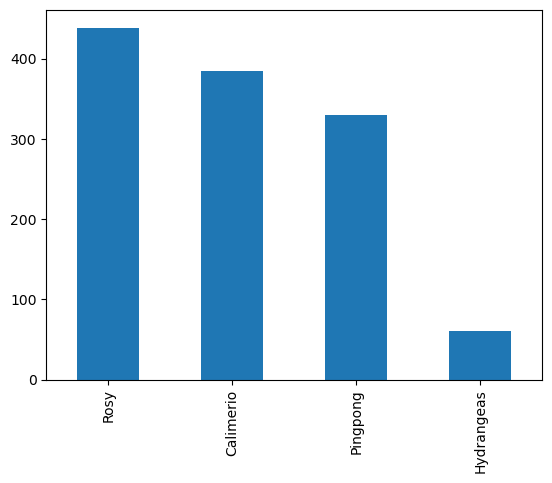

In [38]:
additional_dataset['Flower_Types'].value_counts().plot.bar()

In [40]:
# Reset index of items in 2 dataset and combine
base_dataset = base_dataset.reset_index(drop=True)
additional_dataset = additional_dataset.reset_index(drop=True)

combined_df = pd.concat([base_dataset, additional_dataset], ignore_index=True)

combined_df


,Image_Path,Flower_Types
0,./Dataset/Flowers/Tana/tana_297.jpg,Tana
1,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum
2,./Dataset/Flowers/Tana/tana_584.jpg,Tana
3,./Dataset/Flowers/Babi/babi_343.jpg,Babi
4,./Dataset/Flowers/Chrysanthemum/chrysanthemum_...,Chrysanthemum
...,...,...
5830,./Dataset/FlowersAdded/Rosy/rosy_95.jpg,Rosy
5831,./Dataset/FlowersAdded/Rosy/rosy_96.jpg,Rosy
5832,./Dataset/FlowersAdded/Rosy/rosy_97.jpg,Rosy
5833,./Dataset/FlowersAdded/Rosy/rosy_98.jpg,Rosy


               Flower_Types
Lisianthus              969
Babi                    931
Calimerio               738
Chrysanthemum           696
Pingpong                690
Tana                    623
Rosy                    610
Hydrangeas              578


               Flower_Types
Lisianthus         0.166067
Babi               0.159554
Calimerio          0.126478
Chrysanthemum      0.119280
Pingpong           0.118252
Tana               0.106769
Rosy               0.104542
Hydrangeas         0.099057


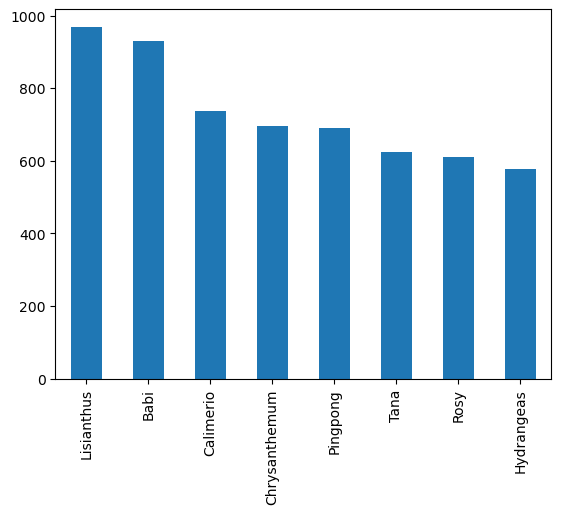

In [19]:
# Ok it solve a bit of imbalance dataset

combined_df['Flower_Types'].value_counts().plot.bar()

print(combined_df['Flower_Types'].value_counts().to_frame())
print("\n")
print(combined_df['Flower_Types'].value_counts(normalize=True).to_frame())

In [43]:
# Track which images are duplicated
duplicates_images = find_duplicate_images(base_dir, additional_dir)

duplicated_result = [item for sublist in duplicates_images[:] for item in sublist[1:]]
print("Amount of duplicated images: " + str(len(duplicated_result)))

# Remove in combined dataset not in real dataset
combined_df = combined_df[~combined_df['Image_Path'].isin(duplicated_result)]

# Reset index of combined dataframe 
combined_df.reset_index(drop=True, inplace=True)

# Check if the size of combined dataset is decrease after removed
combined_df.shape

Amount of duplicated images: 34


(5801, 2)

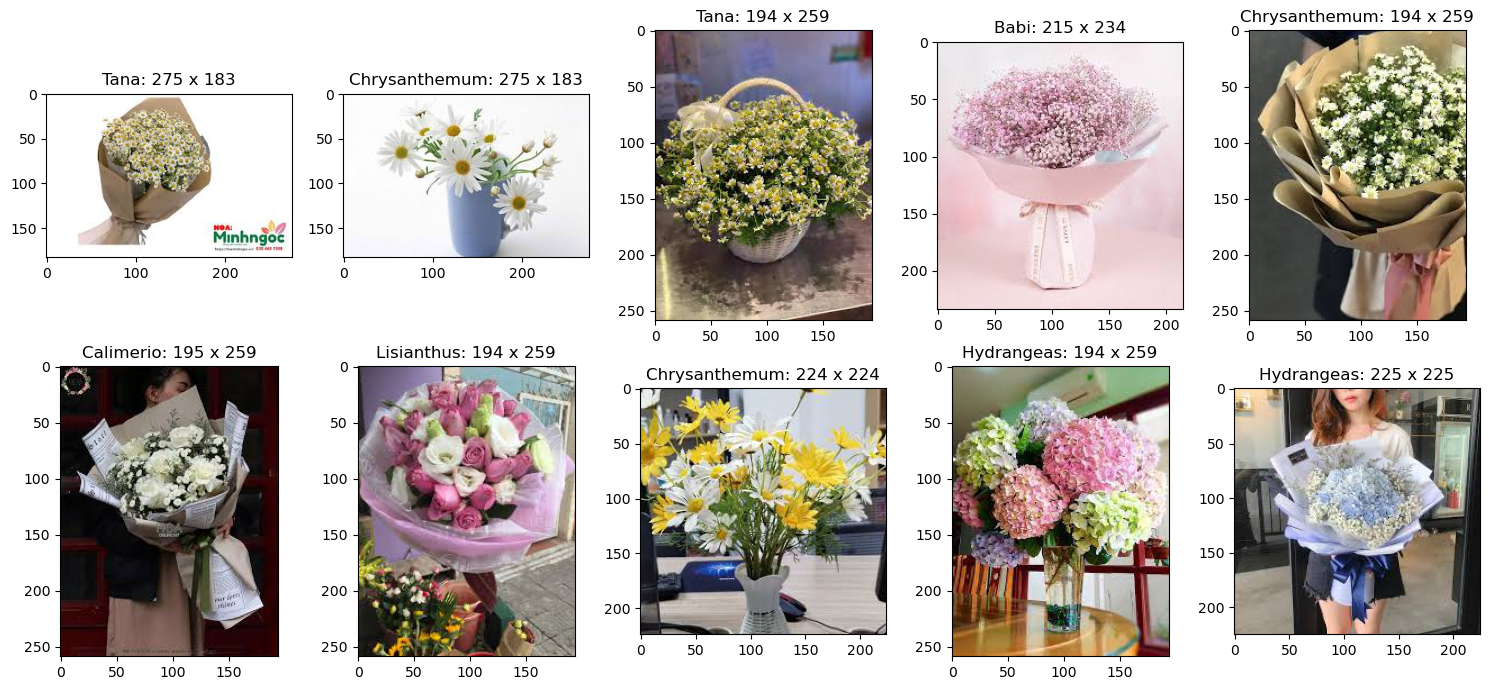

In [74]:
# Check image for image overview (contain name and size of flower images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(combined_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(combined_df.loc[i, "Flower_Types"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

### Split data into dev and test and prepare for data augmentation and normalization

In [51]:
# Split data into dev and test, dev will use to split again into train and validation (we will use only train and validation set)
dev, test = train_test_split(combined_df, train_size=0.85, shuffle=True, random_state=333)

In [52]:
dev.shape, test.shape

((4930, 2), (871, 2))

In [59]:
#defined
BATCH_SIZE = 32

IMG_WIDTH  = 224
IMG_HEIGHT = 224

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=25,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [60]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Flower_Types',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4191 validated image filenames belonging to 8 classes.
Found 739 validated image filenames belonging to 8 classes.
Found 871 validated image filenames.


In [61]:
# Check class in train set
print(train_ds.class_indices)

{'Babi': 0, 'Calimerio': 1, 'Chrysanthemum': 2, 'Hydrangeas': 3, 'Lisianthus': 4, 'Pingpong': 5, 'Rosy': 6, 'Tana': 7}


(32, 224, 224, 3)
(32, 8)
Label:  [0. 0. 1. 0. 0. 0. 0. 0.]


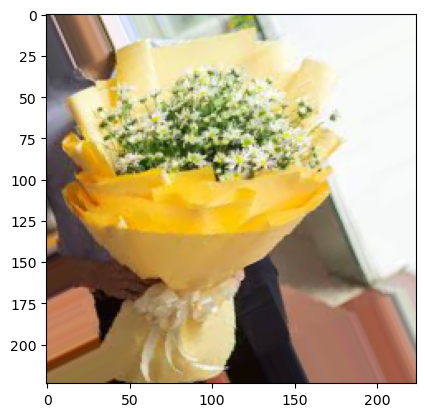

Label:  [0. 0. 0. 1. 0. 0. 0. 0.]


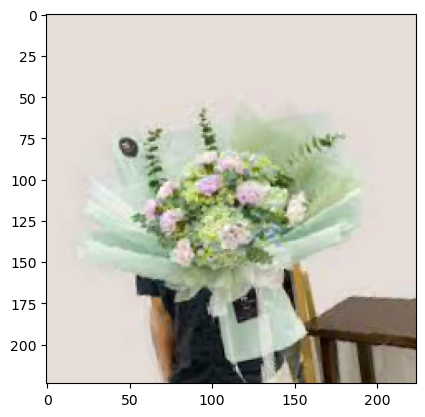

Label:  [0. 0. 0. 0. 0. 1. 0. 0.]


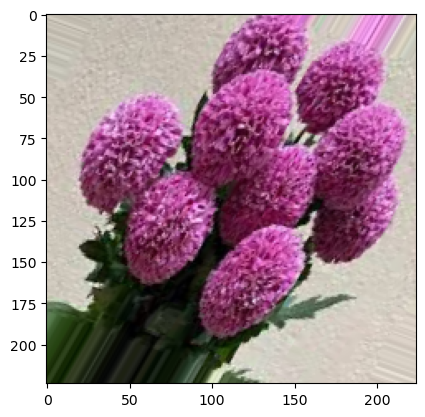

In [62]:
# Check image after data augmentation and normalization
batchX, batchY = train_ds.next()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

### Model Construction Building

In [63]:
model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
    
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2)),

    Flatten(),
    Dropout(0.5),
    Dense(units=1024, activation='relu'),
    Dropout(0.5),
    Dense(units=512, activation='relu'),

    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

### Fine tuning and preparation for model training

In [64]:
# Fine tuning for Adam and Early Stopping function
optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

# Test with Epoch of 45
history = model.fit(train_ds, validation_data=val_ds, epochs=45, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])

Epoch 1/45
131/131 [==============================] - 88s 581ms/step - loss: 2.0833 - accuracy: 0.1638 - val_loss: 2.0065 - val_accuracy: 0.2300
Epoch 2/45
131/131 [==============================] - 58s 442ms/step - loss: 1.9975 - accuracy: 0.2249 - val_loss: 1.9069 - val_accuracy: 0.2842
Epoch 3/45
131/131 [==============================] - 54s 415ms/step - loss: 1.9002 - accuracy: 0.2855 - val_loss: 1.8281 - val_accuracy: 0.3315
Epoch 4/45
131/131 [==============================] - 56s 429ms/step - loss: 1.7836 - accuracy: 0.3357 - val_loss: 1.5782 - val_accuracy: 0.4181
Epoch 5/45
131/131 [==============================] - 55s 416ms/step - loss: 1.5694 - accuracy: 0.4202 - val_loss: 1.5019 - val_accuracy: 0.4493
Epoch 6/45
131/131 [==============================] - 55s 417ms/step - loss: 1.4835 - accuracy: 0.4592 - val_loss: 1.4924 - val_accuracy: 0.4452
Epoch 7/45
131/131 [==============================] - 63s 483ms/step - loss: 1.3973 - accuracy: 0.4772 - val_loss: 1.4551 - val_ac

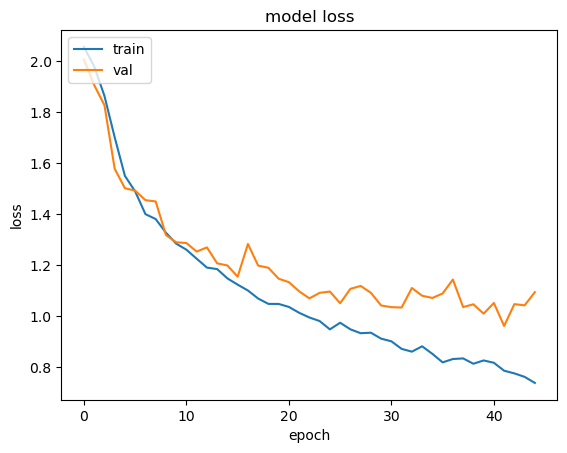

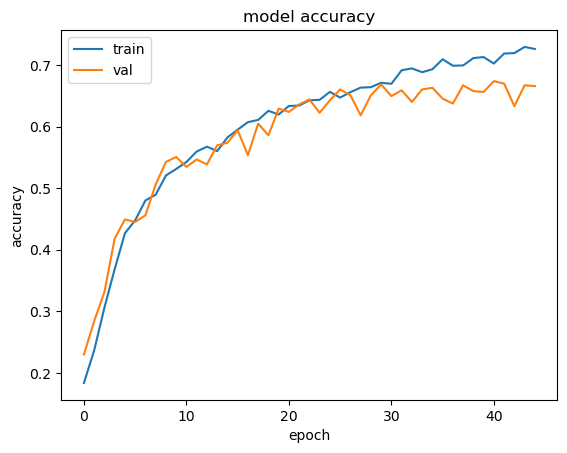

In [68]:
# Line Chart for showing loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
# Test overall accuracy final
batchXTest, batchYTest = val_ds.next()

score = model.evaluate(batchXTest, batchYTest)

1/1 [==============================] - 0s 47ms/step - loss: 0.8121 - accuracy: 0.7500


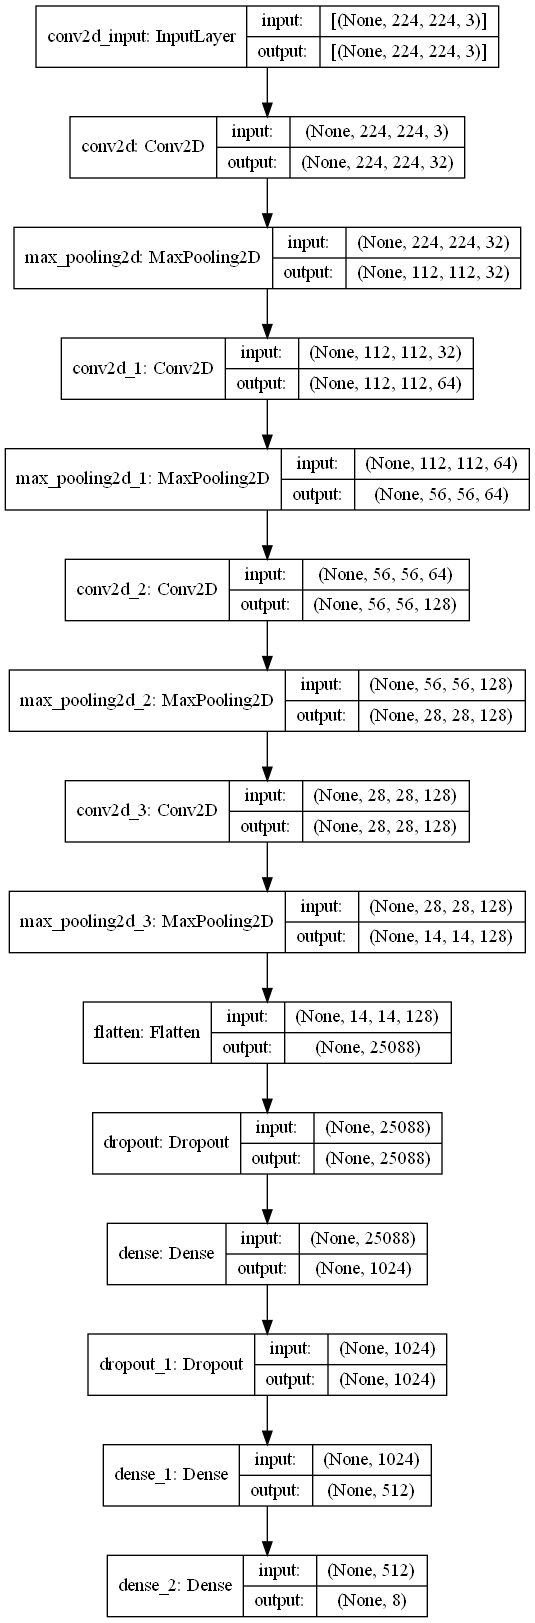

In [40]:
# Model Structure Overview
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [73]:
# Model Saving
model.save('./TrainingModels/flower_classification_model.h5')